In [183]:
import numpy as np
import scipy.linalg as linalg
from dtuimldmtools import similarity
import matplotlib.pyplot as plt
from scipy.linalg import svd
from pandas.plotting import scatter_matrix
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pyplot import figure, legend, plot, show, xlabel, ylabel
# exercise 8.1.1

import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import rlr_validate

# fetch dataset 
# wine = fetch_ucirepo(id=109) 
  
# # data (as pandas dataframes) 
# X = wine.data.features 
# y = wine.data.targets 

# totaldata= (wine.data)
  
# metadata 
# print(wine.metadata) 
  
# variable information 
# print(wine.variables) 

# OFFLINE LOADING OF DATA
X = np.loadtxt('./wine/wine.data', delimiter=',')
y = X[:,0]
X = np.delete(X,0,axis=1)
# y = np.loadtxt('./wine/wine.names', delimiter=',')

Xorig = X
# Standardizing the data

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# One of K encoding
# y = similarity.one_of_k(y)

# Ensure y values are within the range of the identity matrix's size
num_classes = int(np.max(y)) + 1
y2 = np.eye(num_classes)[y.astype(int)]

#removing first column of y
y2 = y2[:,1:]

#Appending y to X
X = np.append(X,y2,axis=1)

#Extracting the first column of X
y = X[:,0]



attributeNames = [
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity of ash",
    "Magnesium",
    "Total phenols",
    "Flavanoids",
    "Nonflavanoid phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315 of diluted wines",
    "Proline"
]

#Removing the first column of X
X = np.delete(X,0,axis=1)
# Removing alcohol from attributenames
attributeNames = attributeNames[1:]


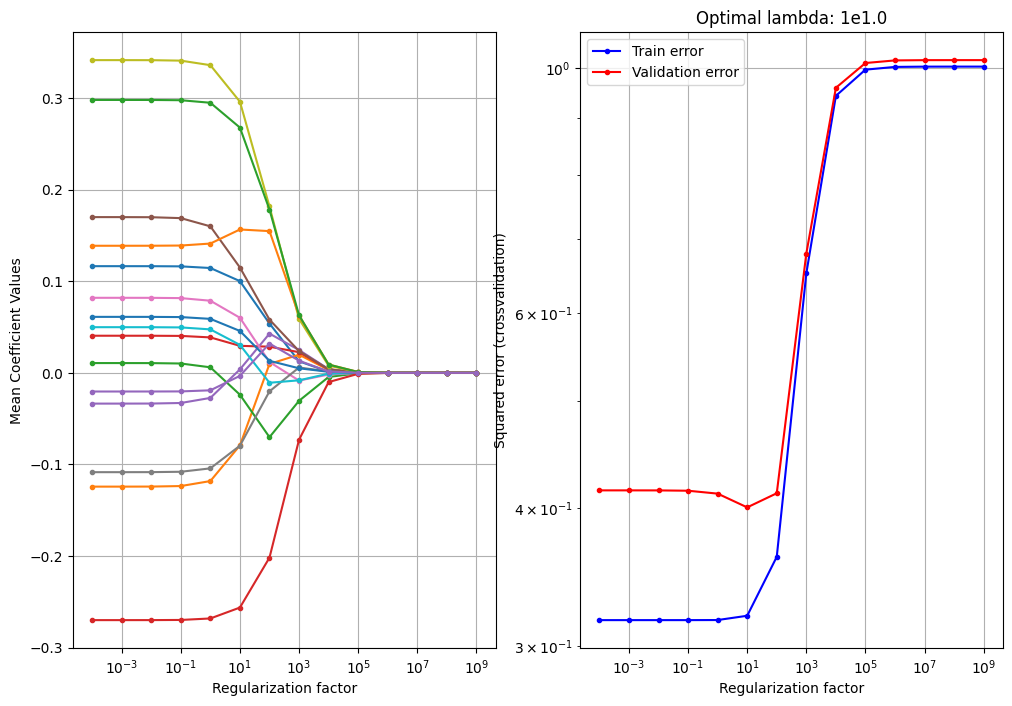

Linear regression without feature selection:
- Training error: 0.3333446141875747
- Test error:     0.4185518070400788
- R^2 train:     0.6662573562581006
- R^2 test:     0.5371429519969592

Regularized linear regression:
- Training error: 0.3361631389027877
- Test error:     0.4048799203805696
- R^2 train:     0.6634354660883743
- R^2 test:     0.5522620579078952

Weights in last fold:
         Offset            -0.0
     Malic acid             0.1
            Ash           -0.08
Alcalinity of ash           -0.02
      Magnesium            0.03
  Total phenols             0.0
     Flavanoids            0.12
Nonflavanoid phenols            0.06
Proanthocyanins           -0.08
Color intensity             0.3
            Hue            0.03
OD280/OD315 of diluted wines            0.05
        Proline            0.16
Ran Exercise 8.1.1


In [184]:
#Generalization error
#two-fold K=10 fold cross validation 
# K = 10
# N = X.shape[0]
# M = X.shape[1]
# #splitting the data into K folds
# fold_size = N//K
# np.random.shuffle(X)
# folds = np.split(X, K)

N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-4, 10))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()

# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
# print(M)
# print(attributeNames)
for m in range(M-3):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")



In [ ]:
# exercise 5.2.2

# Fit ordinary least squares regression model
model = lm.LinearRegression(fit_intercept=True)
model = model.fit(X, y)
# Compute model output:
y_est = model.predict(X)
#ændring
# Or equivalently:
# y_est = model.intercept_ + X @ model.coef_


# Plot original data and the model output
# f = figure()

# plot(X, y, ".")
# plot(X, y_true, "-")
# plot(X, y_est, "-")
# xlabel("X")
# ylabel("y")
# legend(["Training data", "Data generator", "Regression fit (model)"])

# show()

# print("Ran Exercise 5.2.2")
